# This file can be used to reproduce Figure 5.b of the paper.

In [1]:
from ordered_set import OrderedSet
import wandb
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

font_size = 14
font_size_legend = 12
font_size_title = 8

plt.rc('font', size=font_size)  # controls default text sizes
plt.rc('axes', titlesize=font_size_title)  # fontsize of the axes title
plt.rc('axes', labelsize=font_size)  # fontsize of the x and y labels
plt.rc('xtick', labelsize=font_size)  # fontsize of the tick labels
plt.rc('ytick', labelsize=font_size)  # fontsize of the tick labels
plt.rc('legend', fontsize=font_size_legend)  # legend fontsize
plt.rc('figure', titlesize=font_size_title)  # fontsize of the figure title
plt.rcParams['figure.figsize'] = [8, 6]
plt.rcParams['figure.dpi'] = 80 

csfont = {'fontname':'Comic Sans MS'}
hfont = {'fontname':'Helvetica'}

methods_ids = [None, None]

In [2]:
api = wandb.Api()

path_prefix = "akileshbadrinaaraayanan/ContPlay_Hanabi_complete/"

methods_ids[0] = {'ER_easy_SGD':["192tzsan"],
               "ER_easy_Adam": [ "w462mcl1"],
               "AGEM_easy_SGD": ["302wk41s"],
                'AGEM_easy_Adam': [ "2hw4tgxi"],
                "EWC_online_easy_SGD": [   "3qy8s35u"],
                "EWC_online_easy_Adam": [    "18rgb8st"],
                'EWC_offline_easy_SGD':[ "2vfo5y8q"],
                "EWC_offline_easy_Adam": [        "2ebneo1j"],
                "Naive_easy_SGD": [ "dtovcl78"],
                "Naive_easy_Adam": [ "2ntz93hk"  ],
                "Multi_task_easy_SGD": [    "3c9q25lp" ],
                "Multi_task_easy_Adam": [  "3izs7koe"]}

In [3]:

methods_ids[1] = {'ER_hard_SGD':[ "v2vxaftm"],
               'ER_hard_Adam': [ "aum2srti"],
               "AGEM_hard_SGD": ["1l6yl2nq"],
                "AGEM_hard_Adam": ["2uqcp7m7"],
                "EWC_online_hard_SGD": [ "1udoq5y8"],
                "EWC_online_hard_Adam": ["1dnf4q0h"],
                'EWC_offline_hard_SGD':["3bd53mmg"],
                "EWC_offline_hard_Adam": ["3qeia22a"],
                "Naive_hard_SGD": ["k7yn9xj9"],
                "Naive_hard_Adam": ["ne4hgwbr"],
                "Multi_task_hard_SGD": ["259sh777"],
                "Multi_task_hard_Adam": ["17pe2yoi"]
               }

In [4]:
results_dict = [{}, {}]
for i in range(2):
    for method in methods_ids[i].keys():
        all_results, all_configs = [], []
        for seed in range(len(methods_ids[i][method])):
            run = api.run(path_prefix + methods_ids[i][method][seed])
            history = run.scan_history()

            results = {key:[] for key in run.history().columns}
            for row in history:
                for key in row.keys():
                    results[key].append(row[key])
            results['epoch_zeroshot'] = OrderedSet(results['epoch_zeroshot'])
            all_results.append(results)
            all_configs.append(run.config)
        results_dict[i][method] = all_results
        results_dict[i][method+'_configs'] = all_configs

## Testing the learner against a set of unseen agents at the end of each task.

findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.


HARD agents, perfect_zeroshot_19


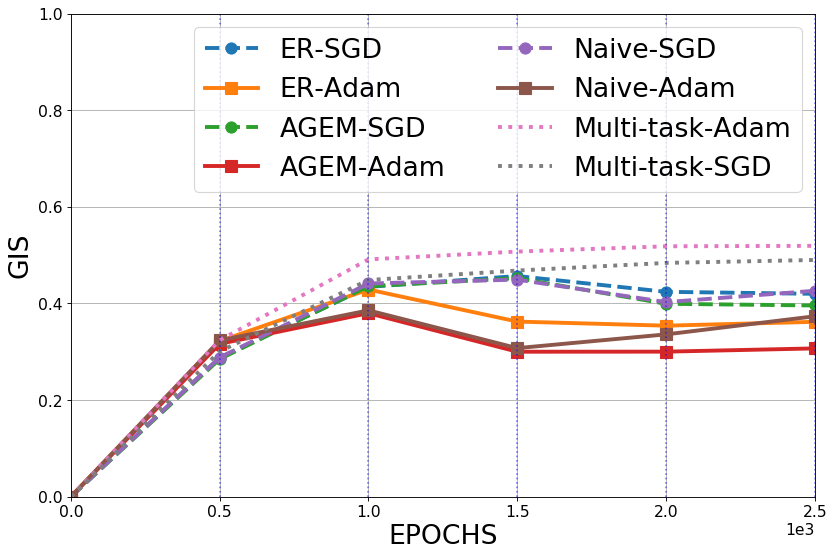

In [5]:
num_tasks = 5
task_length = 500
Agent_types = ['HARD']
y_labels = ["GIS"]

x_axises = ["epoch_zeroshot"]

methods_to_plot = [['ER_easy_SGD',
                   "ER_easy_Adam",
                   "AGEM_easy_SGD",
                    'AGEM_easy_Adam',
#                     "EWC_online_easy_SGD",
#                     "EWC_online_easy_Adam",
                    "Naive_easy_SGD",
                    "Naive_easy_Adam",
                    "Multi_task_easy_Adam",
                   "Multi_task_easy_SGD"], 
                   ['ER_hard_SGD',
                   "ER_hard_Adam",
                   "AGEM_hard_SGD",
                    'AGEM_hard_Adam',
#                     "EWC_online_hard_SGD",
#                     "EWC_online_hard_Adam",
                    "Naive_hard_SGD",
                    "Naive_hard_Adam",
                    "Multi_task_hard_Adam",
                   "Multi_task_hard_SGD"]]

for k in range(len(Agent_types)):
    if not os.path.exists('plots/full_cruves/' + Agent_types[k]):
        os.makedirs('plots/full_cruves/' + Agent_types[k])
    
    fig = plt.figure(figsize=(12,8))
    ax = fig.subplots(nrows=1, ncols=1)
    for method in methods_to_plot[k]:
        if len(results_dict[k][method]) > 0:
            if len(method.split('_')) == 3:
                label = method.split('_')[0] + '-' + method.split('_')[2]
            elif len(method.split('_')) == 4:
                label = method.split('_')[0] + '-' + method.split('_')[1] + '-' + method.split('_')[3]

            y = np.zeros((20, len(results_dict[k][method][0][x_axises[0]])))
            i = 0
            for metric in results_dict[k][method][0].keys():
                if metric.split('_')[0] == 'final':
                    y[i, :len(results_dict[k][method][0][metric])] = np.array(results_dict[k][method][0][metric])
                    i += 1
            
            if method.split('_')[-1] == 'SGD':
                ls = '--o'
            elif method.split('_')[-1] == 'Adam':
                ls = '-s'

            if method.split('_')[0] == 'Multi':
                ls = ':'
            N = 2
            y_mean = np.convolve(y.mean(axis=0), np.ones(N)/N, mode='full')[:-N+1]
            ax.plot(results_dict[k][method][0][x_axises[0]],  (y_mean - y_mean[0])/25, ls, markersize=10,  alpha=1, lw=3.5, label=label)

    for i in range(num_tasks):
        ax.plot([task_length*(i+1)]*50, np.linspace(0, 25, 50), 'b:', alpha=0.5)

    ax.set_ylim([0, 1])
    ax.set_xlim([0, 2.5e3])

    ax.grid()
    ax.set_xlabel('EPOCHS', **hfont)
    ax.set_ylabel(y_labels[0], **hfont)
    ax.xaxis.label.set_fontsize(24)
    ax.yaxis.label.set_fontsize(24)
    print(Agent_types[k] + ' agents, ' + metric)
    ax.legend(loc='best', ncol=2, prop={'size': 24})
    ax.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
#     ax.tick_params(axis='x',Labelsize=24)
    plt.savefig('plots/full_cruves/' + Agent_types[k] + '/' + 'GIS' +'.png', dpi=200)
    plt.show()
